In [ ]:
#==========================================
# Title:  Options Price (Put) Predictor using MLP1 Model
# Author: Vachan
# Email : vachan@iitb.ac.in
#==========================================

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras import backend
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import norm
import numpy as np

In [2]:
excel_file = pd.ExcelFile("ASIANPAINT_Dataset.xlsx")
pe_sheets = ['PE2017', 'PE2018', 'PE2019', 'PE2020']
df = pd.concat([excel_file.parse(sheet) for sheet in pe_sheets], ignore_index=True).dropna().reset_index().drop(columns=['index'])

In [3]:
# Hyperparams
n_units = 400
layers = 4
n_batch = 4096
n_epochs = 100

In [4]:
df.strike_price = df.strike_price / 100
df.underlying_value = df.underlying_value / 100

In [5]:
df

,Date,Expiry,t,strike_price,underlying_value,sigma,r,close
0,2017-01-02,2017-01-25,23,13.6,9.0465,0.014319,0.0619,258.90
1,2017-01-02,2017-01-25,23,7.0,9.0465,0.014319,0.0619,0.05
2,2017-01-02,2017-01-25,23,14.0,9.0465,0.014319,0.0619,295.95
3,2017-01-02,2017-01-25,23,14.2,9.0465,0.014319,0.0619,314.75
4,2017-01-02,2017-01-25,23,13.0,9.0465,0.014319,0.0619,205.40
...,...,...,...,...,...,...,...,...
111861,2020-12-31,2021-02-25,56,21.4,27.6450,0.015889,0.0308,146.80
111862,2020-12-31,2021-02-25,56,21.6,27.6450,0.015889,0.0308,157.00
111863,2020-12-31,2021-02-25,56,21.8,27.6450,0.015889,0.0308,167.55
111864,2020-12-31,2021-02-25,56,22.0,27.6450,0.015889,0.0308,178.50


In [6]:
put_X_train, put_X_test, put_y_train, put_y_test = train_test_split(df.drop(columns=['Date', 'Expiry']), df.drop(columns=['Date', 'Expiry', 't','strike_price', 'underlying_value', 'sigma', 'r']), test_size=0.20, random_state=42)

In [7]:
model = Sequential()
model.add(Dense(n_units, input_dim=put_X_train.shape[1]))
model.add(LeakyReLU())

for _ in range(layers - 1):
    model.add(Dense(n_units))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

model.add(Dense(1, activation='relu'))

model.compile(
    optimizer = "adam",
    loss = "mse",
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
  )

C:\Users\vacha\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
history = model.fit(put_X_train, put_y_train, 
                    batch_size=n_batch, epochs=n_epochs, 
                    validation_split = 0.01,
                    callbacks=[TensorBoard()],
                    verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - loss: 24625.2480 - root_mean_squared_error: 156.8739 - val_loss: 517.5828 - val_root_mean_squared_error: 22.7504
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 21545.9805 - root_mean_squared_error: 146.7812 - val_loss: 3647.2644 - val_root_mean_squared_error: 60.3926
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 19794.8184 - root_mean_squared_error: 140.6896 - val_loss: 8527.3545 - val_root_mean_squared_error: 92.3437
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 18060.7207 - root_mean_squared_error: 134.3849 - val_loss: 10564.1367 - val_root_mean_squared_error: 102.7820
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 16395.6543 - root_mean_squared_error: 128.0398 - val_loss: 11372.7295 - val_root_mean_squared_error: 106.6430
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 14744.3613 - root_mean_squared_error: 121.4088 - val_loss: 10405.7900 - val_root_mean_squa

In [9]:
model.save('mlp1-put.h5')

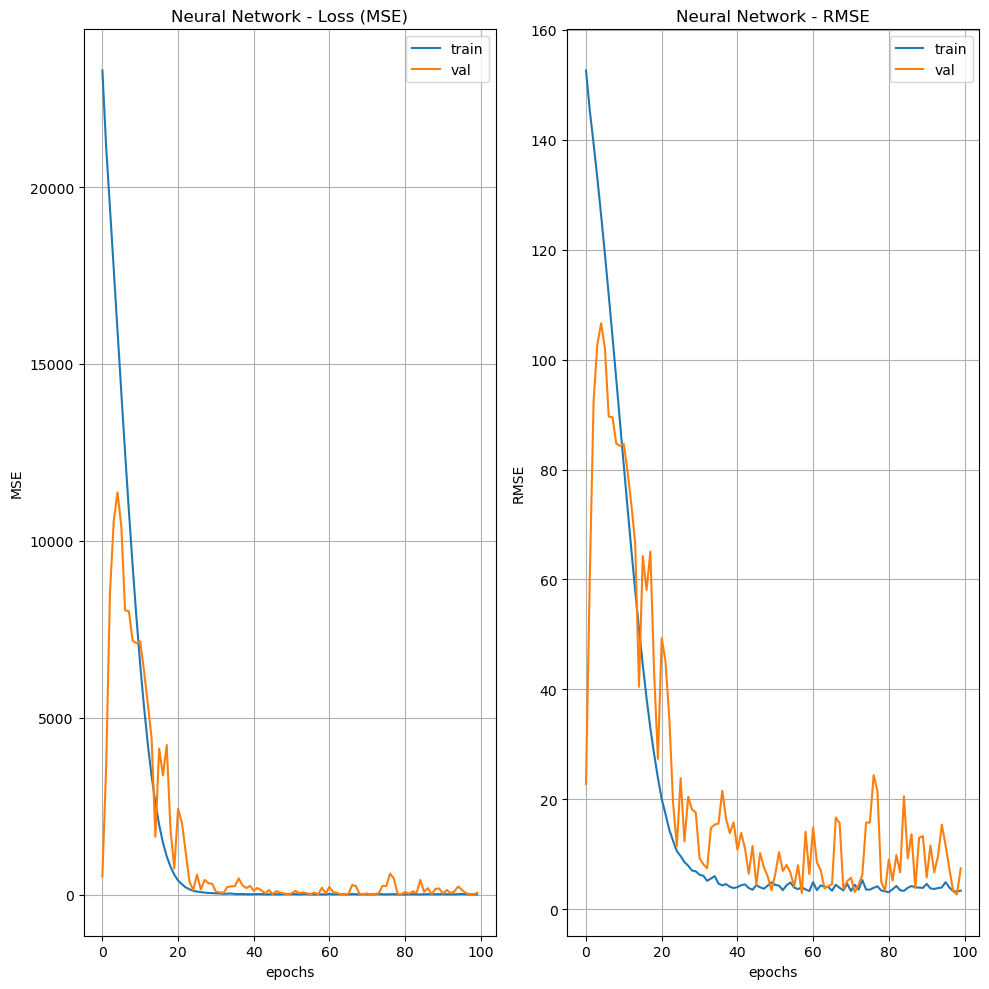

In [10]:
plt.figure(figsize=(10,10))


plt.subplot(1,2,1)
plt.plot(list(range(n_epochs)), history.history["loss"], label="train")
plt.plot(list(range(n_epochs)), history.history["val_loss"], label="val")
plt.title("Neural Network - Loss (MSE)")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(list(range(n_epochs)), history.history["root_mean_squared_error"], label="train")
plt.plot(list(range(n_epochs)), history.history["val_root_mean_squared_error"], label="val")
plt.title("Neural Network - RMSE")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.legend()

plt.tight_layout()
plt.grid()
plt.savefig('Put_model_learning_curve.png')

In [11]:
put_y_pred =model.predict(put_X_test)

700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [12]:
print("MLP-1 model RMSE:\t",mean_squared_error(put_y_pred, put_y_test)**0.5)

MLP-1 model RMSE:	 6.9311097853015875


In [13]:
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price


In [14]:
# Extract necessary columns from the test set
S = put_X_test['underlying_value']*100 # rescaled
K = put_X_test['strike_price']*100     # rescaled
T = put_X_test['t']/365                # always measured in years
r = put_X_test['r']               
sigma = put_X_test['sigma']

# Compute Black-Scholes predictions
bs_predictions = black_scholes_put(S, K, T, r, sigma)


In [15]:
bs_rmse = mean_squared_error(put_y_test, bs_predictions, squared=False)
bs_rmse


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


88.54763830543305

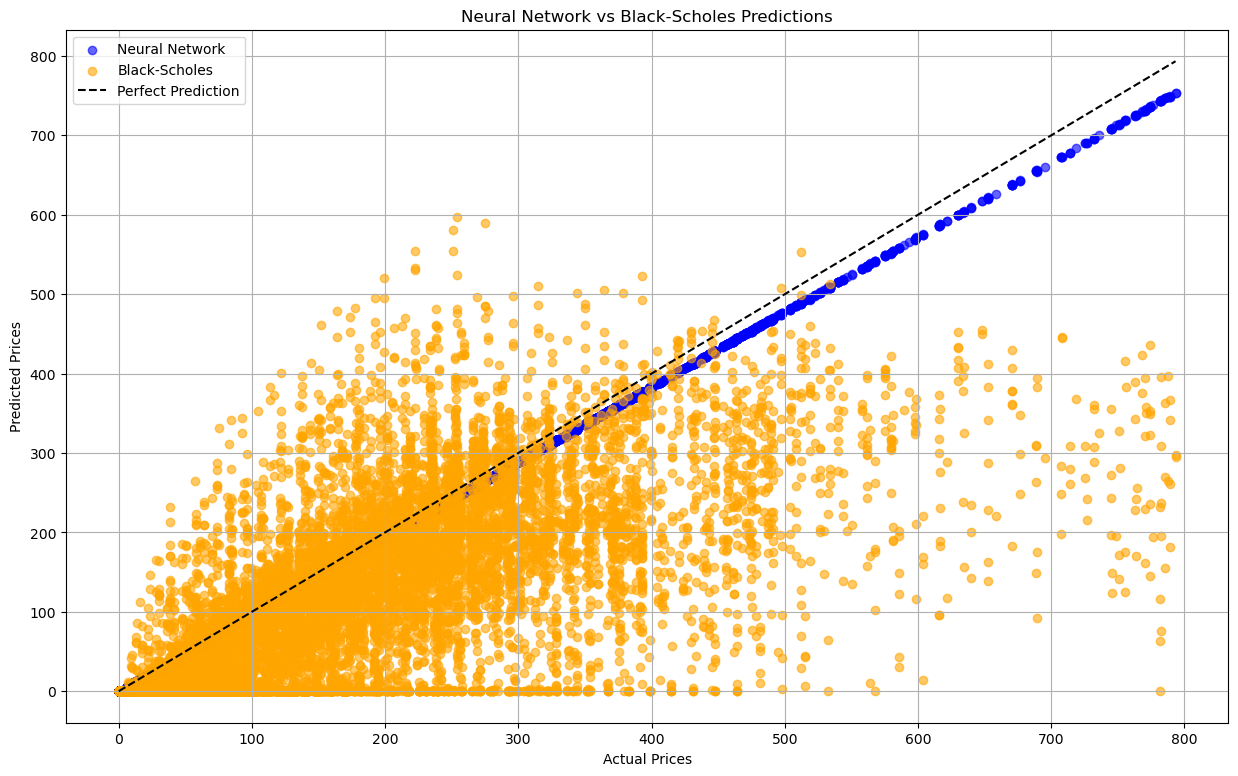

In [16]:
plt.figure(figsize=(15, 9))
# Scatter plot for NN predictions
plt.scatter(put_y_test, put_y_pred, alpha=0.6, label='Neural Network', color='blue')
# Scatter plot for Black-Scholes predictions
plt.scatter(put_y_test, bs_predictions, alpha=0.6, label='Black-Scholes', color='orange')

plt.plot([put_y_test.min(), put_y_test.max()], [put_y_test.min(), put_y_test.max()], 'k--', label="Perfect Prediction")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.title("Neural Network vs Black-Scholes Predictions")
plt.grid()
plt.show()